In [1]:
from ewex import *
import numpy as np
from copy import deepcopy
import matplotlib as mp

#  Example: PFAS in the "semi-closed water cycle"

The semi-closed water cycle is a combination of wastewater treatment, dilutions processes in surface water and groundwater, bank filtration and drinking water treatment.

In this example the exposure to 14 substancesis simulated. The data sent contains removal data for one of them (PFOA) as an example. Additional literature data can manually be added. However, the simulation even runs without literature data, using the prior information only. Case study specific data, like on-site measurements, can be added to further refine the results.

To run a simulation, a starting concentration and a tolerable final concentration (reference value) must be provided. In case of mixture processes, like dilution by surface water, this information is needed additionally.  

## 1. Enter starting concentration and reference value per substance
### Starting concentrations
As a starting concentration the maximum value from the PROMISCES HHEA Dataset was used per substance in raw wastewter.

### Reference values
Reference values for the single PFAS substances are derived from the threshold of PFAS-20 sum according to the European drinking water directive. The threshold value for all 20 PFAS is 100 ng/L, equally distributed among the 20 substances that leads to 5 ng/L per substance. However, substances have a different toxicity which need to be considered. This can be done by using Relative Potancy Factors (RPFs) in relation to PFOA toxicity (ex. the RPF of PFOA and PFOS is 1 and 2, respectively. That leads to single compound threshold of 5 ng/L and 2.5 ng/L)
The RPFs were taken from:

"RIVM 2025":https://www.rivm.nl/pfas/rpf
(accessed 2025-04-15)

based on 

[1] Bil W, Zeilmaker M, Fragki S, Lijzen J, Verbruggen E, Bokkers B. 2021. Risk assessment of per‐ and polyfluoroalkyl substance mixtures: a relative potency factor approach. Environ Toxicol Chem 40 (3): 859–870. 

[2] RIVM. 2022. RIVM-VSP (Veiligheid Stoffen en Producten) Advies 14434A02–Drinkwaterrichtwaarde voor trifluorazijnzuur, 02-02-2022. 

[3] Smit CE (Conformité Européenne), Verbruggen EMJ. 2022. Risicogrenzen voor PFAS in oppervlaktewater. Doorvertaling van de gezondheidskundige grenswaarde van EFSA (Europese Voedselveiligheidsautoriteit) naar concentraties in water. RIVM Briefrapport 2022-0074.  


### Special case PFPeS and TFMSA
To possible solutions to include substance without any knowledge about their concentration:
 - For PFPeS there was no concentration in raw wastewater available. Instead a concentration 100 times the reference value was used. 

 - For TFMSA neither starting concentration nor reference value were available. It was decided to conduct a relative assessment where reference value and starting conentration were set to 1 and 100, respectively.


In [2]:
# substances
substances = [
    Substances.pfos \
        .with_starting_concentration(StartingConcentration(np.array([50]))) \
        .with_reference(Reference("Bundesministerium für Gesundheit 2023, Zeilmaker et al., 2018 ", 2.5, 2023, "")), 
    Substances.tfmsa \
        .with_starting_concentration(StartingConcentration(np.array([20]))) \
        .with_reference(Reference("No Reference - relative assessment", 1, 0, "")),
    Substances.cbz \
        .with_starting_concentration(StartingConcentration(np.array([6000]))) \
        .with_reference(Reference("UBA GOW (july 2020)", 300, 2020, "")),
]

## 2. Define the treatment train, 
The TreatmentTrain() definition uses a list of treatments as input. All implemented treatments can be called by "Treatments."

In [3]:
base_tt = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco, # additional wastewater treatment: coagulation 
    Treatments.dilsw, # dilution by surface water
    Treatments.npbk, # bank filtration
    Treatments.dilgw, # dilution by groundwater
    Treatments.dwae, # drinking water treatment: aeration
    Treatments.dwrf, # drinking water treatment: rapid filtration
    Treatments.dwac # drinking water treatemtn: activated carbon
])
t1 = TreatmentTrain([
    Treatments.wwtt # primary and secondary wastewater treatment
])
t2 = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco # additional wastewater treatment: coagulation 
])
t3 = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco, # additional wastewater treatment: coagulation 
    Treatments.dilsw # dilution by surface water
])
t4 = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco, # additional wastewater treatment: coagulation 
    Treatments.dilsw, # dilution by surface water
    Treatments.npbk # bank filtration
])

t5 = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco, # additional wastewater treatment: coagulation 
    Treatments.dilsw, # dilution by surface water
    Treatments.npbk, # bank filtration
     Treatments.dilgw # dilution by groundwater
])

t6 = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco, # additional wastewater treatment: coagulation 
    Treatments.dilsw, # dilution by surface water
    Treatments.npbk, # bank filtration
    Treatments.dilgw, # dilution by groundwater
    Treatments.dwae # drinking water treatment: aeration
])

t7 = TreatmentTrain([
    Treatments.wwtt, # primary and secondary wastewater treatment
    Treatments.wwco, # additional wastewater treatment: coagulation 
    Treatments.dilsw, # dilution by surface water
    Treatments.npbk, # bank filtration
    Treatments.dilgw, # dilution by groundwater
    Treatments.dwae, # drinking water treatment: aeration
    Treatments.dwrf # drinking water treatment: rapid filtration
])


In [4]:
asd = RemovalPercent.from_lit(treatment = Treatments.wwtt, substance = Substances.cbz)

## 3. Add mixture data characteristics (Optionally substance specific)
For each mixture process (prefix either "dil" or "sep"), site-specific characteristics need to be added. For mixtures which are not substance-dependent this can simply be done as shown above in the treatment train. If the concentration is specific for a substance, it can be added by looping through the substances and provide a list of mean background concentrations.

In [5]:
# No background concentration in river and groundwater
x_m_river = 0.666
x_sd_river = x_m_river * 0.2
x_m_ground = 0.25
x_sd_ground = x_m_ground * 0.2
c_m_river = []
c_m_ground = []

river_mixture, groundwater_mixture = [], []
for i,s in enumerate(substances):
    river_mixture += [Mixture(x_m_river, x_sd_river, 0, 0)]
    groundwater_mixture  += [Mixture(x_m_ground, x_sd_ground, 0, 0)]
   

## 4. Add site-specific removal factors (optional)
In this example, on-site measurements for the removal by granular activated carbon as drinking water treatment  (dwac) were available. Per treatment step, site specific removal factors can be added. If this is done for a treatment, all substances defined above need to be listed in the same order, even if there is no data available. In this case an empty array can be provided to the RemovalPercent() definition.

In [6]:
# between 10 000 and 20 000 bed volume
removals = {
     Treatments.dwac: {
        Substances.pfos: RemovalPercent(np.array([33,27,28,42,18,69,34])),
        Substances.tfmsa: RemovalPercent(np.array([6,8,5,15,7,3,-3,4])),
        Substances.cbz: RemovalPercent(np.array([99,98,99,98,97,94,99,99]))
     }
}

## 5. Create scenarios to be compared
In our example, we want to compare the exposure to different substances by the same treatment train. One scenario is defined as a unique combination of i) substance, ii) treatment train and iii) treatment properties (including mixture properties). Per substance 1 scenario will be created. By looping through the substances, all substance-specific information can be added.

In [7]:
# create scenarios using treatment trains, substance properties and indput matrix
sc_baseline = []

for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        sc_baseline += [Scenario(
             "wwtp - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t1),
        )]
        
for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        sc_baseline += [Scenario(
            "wwco - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t2),
        )]

for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        t3[2].with_mixture(river_mixture[i])
        sc_baseline += [Scenario(
            "dlsw - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t3),
        )]

for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        t4[2].with_mixture(river_mixture[i])
        sc_baseline += [Scenario(
            "npbf - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t4),
        )]
        
for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        t5[2].with_mixture(river_mixture[i])
        t5[4].with_mixture(groundwater_mixture[i])
        sc_baseline += [Scenario(
            "dlgw - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t5),
        )]
        
for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        t6[2].with_mixture(river_mixture[i])
        t6[4].with_mixture(groundwater_mixture[i])
        sc_baseline += [Scenario(
            "dwae - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t6),
        )]
        
for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        t7[2].with_mixture(river_mixture[i])
        t7[4].with_mixture(groundwater_mixture[i])
        sc_baseline += [Scenario(
            "dwrf - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(t7),
        )]


for i,s in enumerate(substances):
        r = removals[Treatments.dwac][s]
        base_tt[-1].with_removal(r)
        base_tt[2].with_mixture(river_mixture[i])
        base_tt[4].with_mixture(groundwater_mixture[i])
        sc_baseline += [Scenario(
            "dwac - " + f"{s.id}",
            input_matrix = Matrices.rww,
            substance = s,
            treatment_train = deepcopy(base_tt),
        )]



## 6. Run simulation

In [8]:
result_baseline = []
for sc in sc_baseline:
    result_baseline += [sc.simulate_removal(n_runs = 10000)]

wwtt RemovalPercent(arr=array([  -60,  -105,     3,    48,    68,    69,     8,    56,    -8,
          21,    45,     7,    21,   -45,    11,    33,    11,   -21,
          30,   -23,    10,  -433,   -23,   -11,  -191,     0,    50,
        -100,  -106,    47,    50,    56,    16,    78,    19,    64,
          44,    65,    43,    60,    70,    41,   -45,    30,    35,
         -24,     7,    98, -2500,     0,   -92,     0,    77,  -483,
       -2500,     0,   -92,     0,    77,  -483,   -25,    28,    37,
         -30,     1,  -110,    23,    23,   -14,    38,   -29,    24,
          63,    10,   -29,   -19,    23,   -24,   -33,   -11,    62,
          53,    18,    28,    53,    36,   -47,    10,    81,    65,
          65,  -353])) RemovalPercent(arr=array([], dtype=float64))
wwtt RemovalPercent(arr=array([], dtype=int64)) RemovalPercent(arr=array([], dtype=float64))
wwtt RemovalPercent(arr=array([-81, -30,  24])) RemovalPercent(arr=array([], dtype=float64))
wwtt RemovalPercent(ar

wwtt RemovalPercent(arr=array([  -60,  -105,     3,    48,    68,    69,     8,    56,    -8,
          21,    45,     7,    21,   -45,    11,    33,    11,   -21,
          30,   -23,    10,  -433,   -23,   -11,  -191,     0,    50,
        -100,  -106,    47,    50,    56,    16,    78,    19,    64,
          44,    65,    43,    60,    70,    41,   -45,    30,    35,
         -24,     7,    98, -2500,     0,   -92,     0,    77,  -483,
       -2500,     0,   -92,     0,    77,  -483,   -25,    28,    37,
         -30,     1,  -110,    23,    23,   -14,    38,   -29,    24,
          63,    10,   -29,   -19,    23,   -24,   -33,   -11,    62,
          53,    18,    28,    53,    36,   -47,    10,    81,    65,
          65,  -353])) RemovalPercent(arr=array([], dtype=float64))
wwco RemovalPercent(arr=array([15, -5])) RemovalPercent(arr=array([], dtype=float64))
npbk RemovalPercent(arr=array([5])) RemovalPercent(arr=array([], dtype=float64))
dwae RemovalPercent(arr=array([5])) Remov

## 7. Plot results
### Profiles along the treatment train
The concentration and removal factors can be displayed with er_profiles() for selected scenarios (one single scenario is possible). Mixture processes can be excluded from the removal factor plot because the inflow of contaminated water sources can lead to high negative "removal factors" which cannot be compared to the remaining processes.
### Scenario comparison at the end of the treatment train
The spider plot compares the exceedance of the reference value in two or more scenarios. For this purpose, the upper half of the ditribution of the final concentration (50th to 99th quantile) is divided by the reference value. The resulting reference quotient is plotted in color scale.

C:\Users\mzamzo\Documents\python\git\promisces.hhea\promisces\plots.py:49: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(
C:\Users\mzamzo\Documents\python\git\promisces.hhea\promisces\plots.py:82: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(


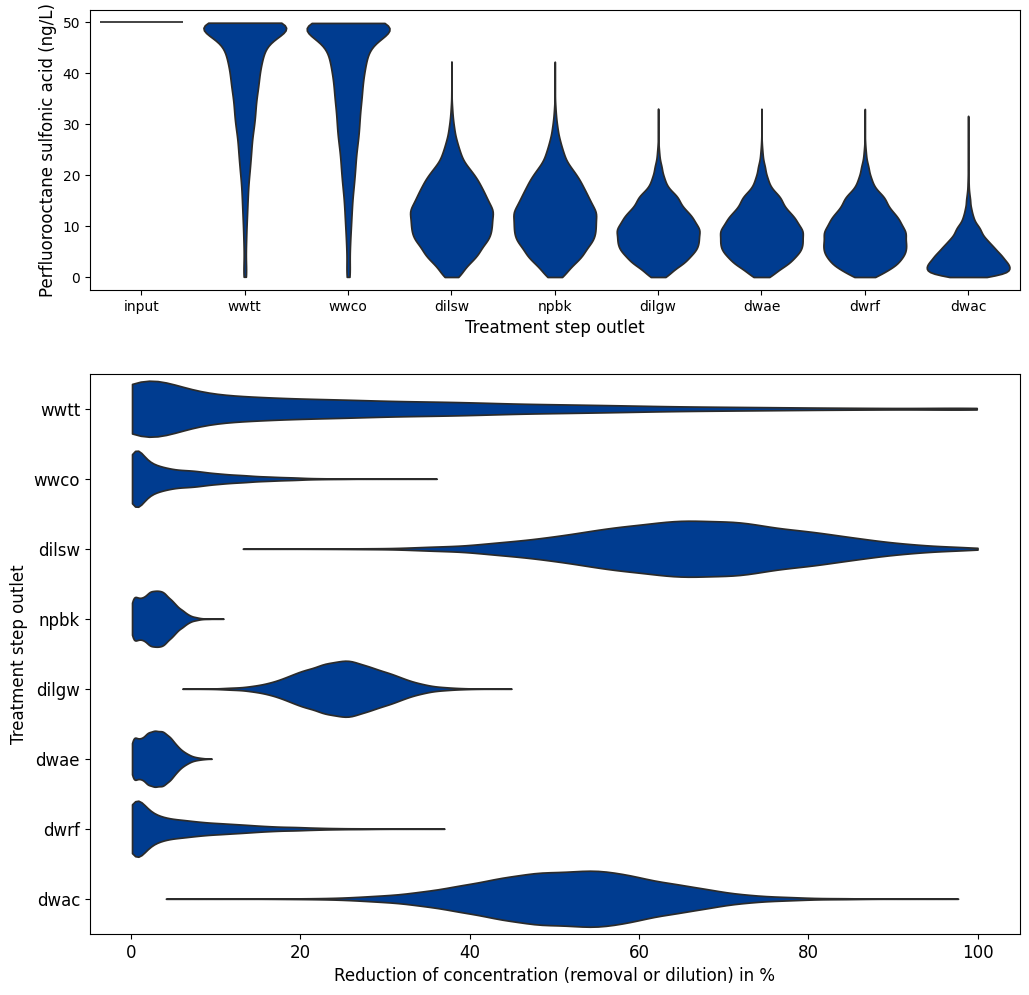

In [9]:
er_profiles(
    sim_results = [result_baseline[21]],
    no_mixture = False,
    color_palette = ['#003C90', '#003C90'],
    reference_value = None
)
plt.show()

In [10]:
index_list = list(range(0, len(result_baseline), 3))

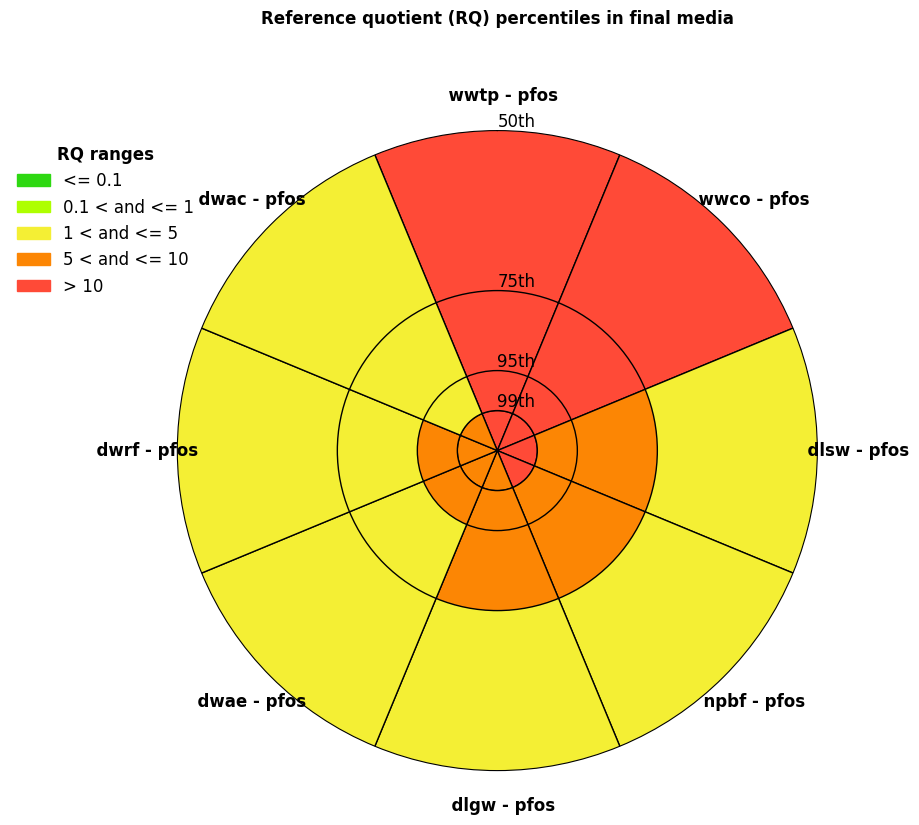

In [11]:
spider_plot(
    [result_baseline[i] for i in index_list],
    case_study_name = ""
)
plt.show()

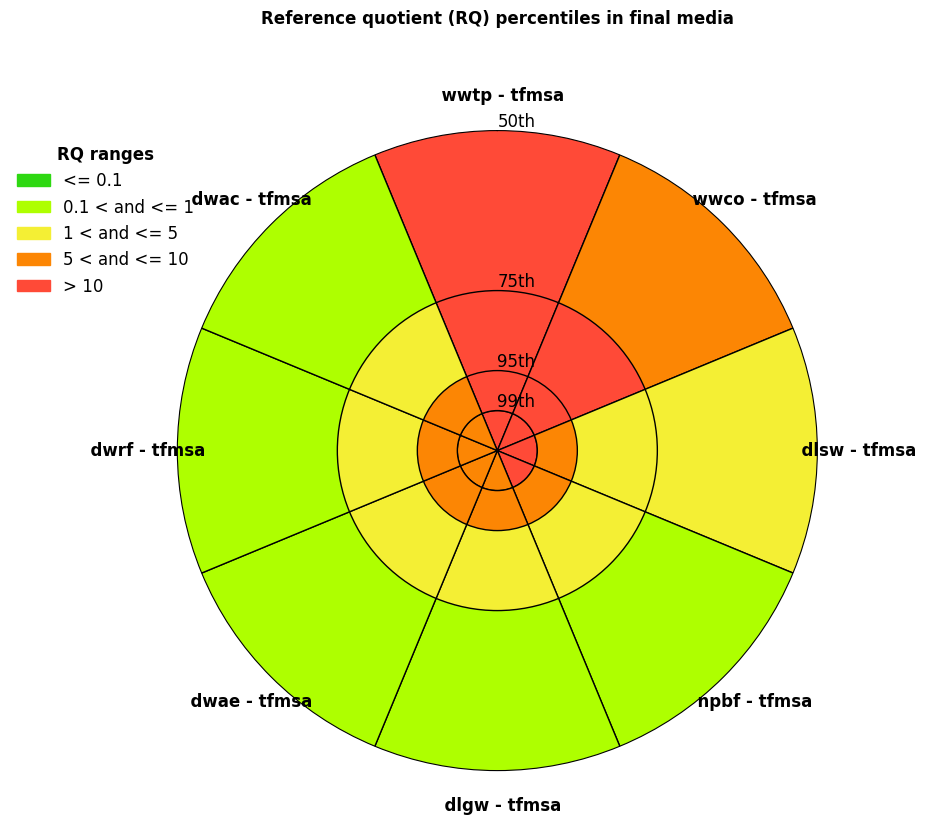

In [12]:
spider_plot(
    [result_baseline[i + 1] for i in index_list],
    case_study_name = ""
)
plt.show()

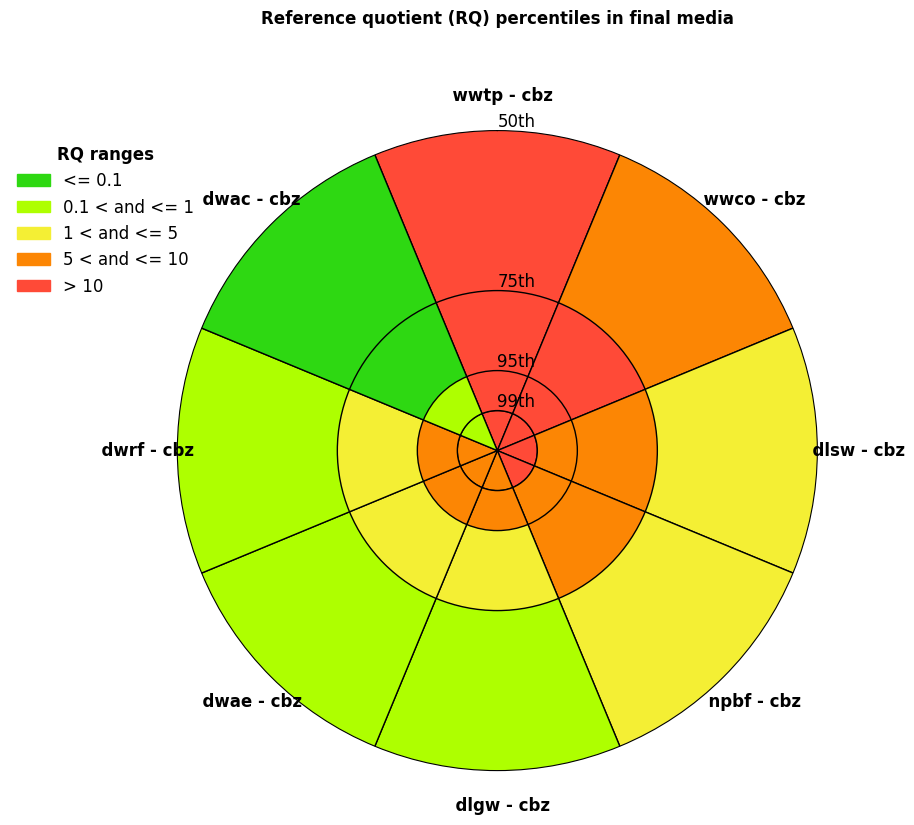

In [13]:
spider_plot(
    [result_baseline[i + 2] for i in index_list],
    case_study_name = ""
)
plt.show()